Notebook para analizar algoritmos cuando se tiene incertidumbre en el tiempo de partida.

En primer lugar definimos el algoritmo a estudiar (por ahora EDF o LLF)

In [1]:
Algorithm = "EDF";

In [2]:
using EVQueues, Plots, Distributions
#using Pkg; Pkg.instantiate()

Se definen los parámetros para realizar las simulaciones

In [21]:
#Desviación standard de la incertidumbre (se modela como una Gaussiana)
sigma=0.2

#Parámetros del resto de la simulación
lambda=60.0;
mu=1;
gamma=1;
C=40.0;
Tfinal=100.0;

#Se agrega snaps para hacer animaciones
snaps = collect(0.1:.5:100.0);

El próximo cuadro compara el desempeño promedio

In [9]:
x = range(0.1,stop=2,length=30)

avgW_alg = zeros(length(x))
avgW_alg_uncertain = zeros(length(x))
avgW_lifo = zeros(length(x))

df = generate_Poisson_stream(lambda,mu,gamma,Tfinal);
df_ref = df;

if Algorithm == "EDF"
    alg = ev_edf_trace(df,C,snaps);
    compute_statistics!(alg);
end

if Algorithm == "LLF"
    alg = ev_llf_trace(df,C);
    compute_statistics!(alg);
end

lifo = ev_lifo_trace(df,C);
compute_statistics!(lifo);

for (i, sigma) in enumerate(x)
    df = df_ref;
    perturbation = Normal(0,sigma)
    reportedDeadlines = [d+rand(perturbation) for d in df[!,:salidas]]
    df[:salidaReportada] = reportedDeadlines
    
    if Algorithm == "EDF"
        alg_uncertain = ev_edf_trace(df,C);
        compute_statistics!(alg_uncertain);
    end
    
    if Algorithm == "LLF"
        alg_uncertain = ev_llf_trace(df,C);
        compute_statistics!(alg_uncertain);
    end

    avgW_alg[i] = alg.stats.avgW;
    avgW_lifo[i] = lifo.stats.avgW;
    avgW_alg_uncertain[i] = alg_uncertain.stats.avgW;

end

avgW_alg = [i * 100 for i in avgW_alg];
avgW_lifo = [i * 100 for i in avgW_lifo];
avgW_alg_uncertain = [i * 100 for i in avgW_alg_uncertain];

Simulando... 100%|██████████████████████████████████████| Time: 0:00:00


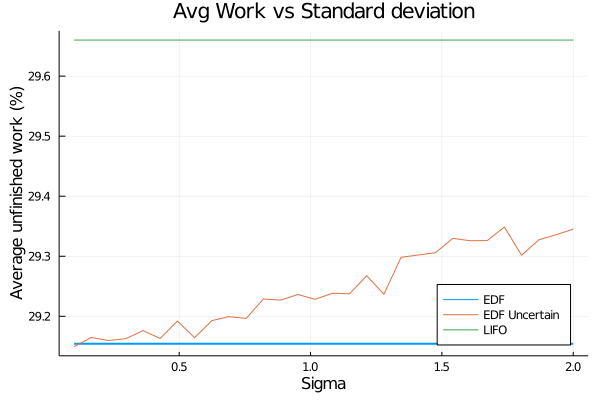

In [10]:
p = plot(  xlabel="Sigma",
            ylabel="Average unfinished work (%)",
            title="Avg Work vs Standard deviation")
plot!(p, x,avgW_alg , label=Algorithm, linewidth=2,legend=:bottomright)
plot!(p, x,avgW_alg_uncertain , label=Algorithm * " Uncertain")
plot!(p, x,avgW_lifo , label="LIFO")

El siguiente cuadro analiza resultados de vehiculos individualmente

In [22]:
df = generate_Poisson_stream(lambda,mu,gamma,Tfinal);

#Se corre el algoritmo "base", esto es, considerando los deadlines reales
if Algorithm == "EDF"
    alg = ev_edf_trace(df,C,snapshots=snaps);
    compute_statistics!(alg);
end

if Algorithm == "LLF"
    alg = ev_llf_trace(df,C,snapshots=snaps);
    compute_statistics!(alg);
end

#Se perturban las salidas, y se simula considerandola como la salida reportada
perturbation = Normal(0,sigma)
reportedDeadlines = [d+rand(perturbation) for d in df[!,:salidas]]
df[:salidaReportada] = reportedDeadlines

if Algorithm == "EDF"
    alg_uncertain = ev_edf_trace(df,C,snapshots=snaps);
    compute_statistics!(alg_uncertain);
end
    
if Algorithm == "LLF"
    alg_uncertain = ev_llf_trace(df,C,snapshots=snaps);
    compute_statistics!(alg_uncertain);
end

alg_evs = sort(alg.EVs,by=ev->ev.arrivalTime)
alg_uncertain_evs = sort(alg_uncertain.EVs,by=ev->ev.arrivalTime)

#para recortar el transitorio
n=Int(Tfinal*lambda/10);
alg_evs = alg_evs[n:end-n]
alg_uncertain_evs = alg_uncertain_evs[n:end-n]

#Guardo resultados de vehiculos
S_alg = [ev.requestedEnergy for ev in alg_evs];
S_alg_uncertain = [ev.requestedEnergy for ev in alg_uncertain_evs];

Sr_alg = [ev.departureWorkload for ev in alg_evs];
Sr_alg_uncertain = [ev.departureWorkload for ev in alg_uncertain_evs];

Sa_alg = S_alg - Sr_alg
Sa_alg_uncertain = S_alg_uncertain - Sr_alg_uncertain;

Simulando... 100%|██████████████████████████████████████| Time: 0:00:00
Simulando... 100%|██████████████████████████████████████| Time: 0:00:00


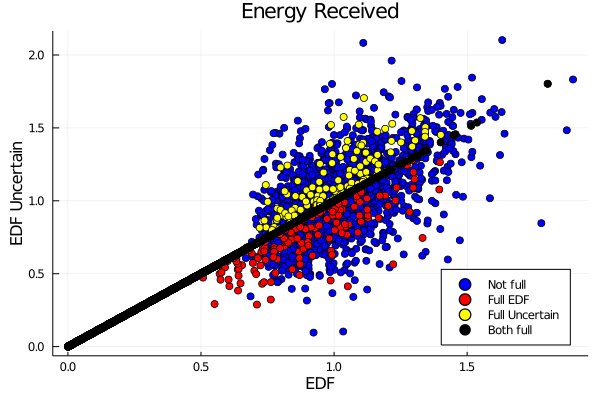

In [7]:
full_alg = [ev.departureWorkload==0 for ev in alg_evs];
full_alg_uncertain = [ev.departureWorkload==0 for ev in alg_uncertain_evs];
a=full_alg.*full_alg_uncertain
b=full_alg.+full_alg_uncertain
both_full = [i>0 for i in a];
both_unfull = [i==0 for i in b];

p = plot(  xlabel=Algorithm,
            ylabel=Algorithm * " Uncertain",
            title="Energy Received", legend=:bottomright)

scatter!(p,Sa_alg[both_unfull.==true],Sa_alg_uncertain[both_unfull.==true],markershape=:circle,markersize=4,color=:blue,label="Not full")
scatter!(p,Sa_alg[full_alg.==true],Sa_alg_uncertain[full_alg.==true],markershape=:circle,markersize=4,color=:red,label="Full "* Algorithm)
scatter!(p,Sa_alg[full_alg_uncertain.==true],Sa_alg_uncertain[full_alg_uncertain.==true],markershape=:circle,markersize=4,color=:yellow,label="Full Uncertain")
scatter!(p,Sa_alg[both_full.==true],Sa_alg_uncertain[both_full.==true],markershape=:circle,markersize=4,color=:black,label="Both full")

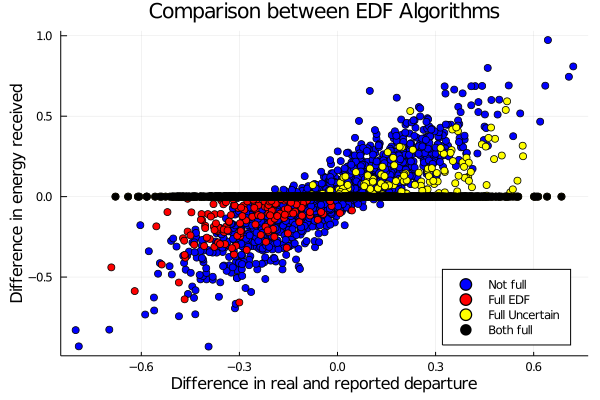

In [8]:
diff_Sa=Sa_alg_uncertain-Sa_alg;
alg_departure = [ev.reportedDepartureTime for ev in alg_evs];
alg_uncertain_departure = [ev.reportedDepartureTime for ev in alg_uncertain_evs];
diff_departure=alg_departure-alg_uncertain_departure;

p = plot(  xlabel="Difference in real and reported departure",
            ylabel="Difference in energy received",
            title="Comparison between " * Algorithm * " Algorithms", legend=:bottomright)

scatter!(p,diff_departure[both_unfull.==true],diff_Sa[both_unfull.==true],markershape=:circle,markersize=4,color=:blue,label="Not full")
scatter!(p,diff_departure[full_alg.==true],diff_Sa[full_alg.==true],markershape=:circle,markersize=4,color=:red,label="Full EDF")
scatter!(p,diff_departure[full_alg_uncertain.==true],diff_Sa[full_alg_uncertain.==true],markershape=:circle,markersize=4,color=:yellow,label="Full Uncertain")
scatter!(p,diff_departure[both_full.==true],diff_Sa[both_full.==true],markershape=:circle,markersize=4,color=:black,label="Both full")

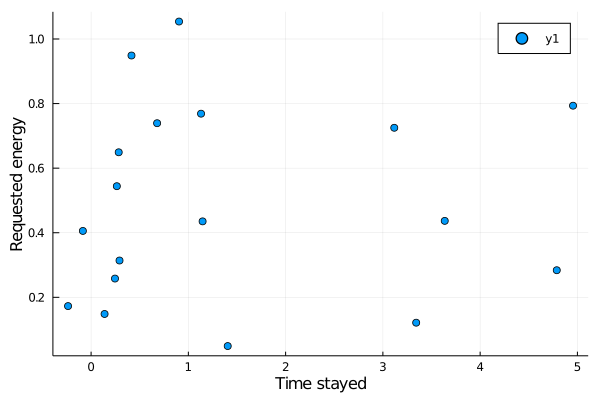

In [9]:
arrival_alg_uncertain = [ev.arrivalTime for ev in alg_uncertain_evs];

index = findall(>(0.5), diff_departure)

departure_check = []
requested_check = []
arrival_check = []

for j = 1:length(index)
    if diff_Sa[index[j]] == 0
        append!(arrival_check,arrival_alg_uncertain[index[j]])
        append!(departure_check, alg_uncertain_departure[index[j]])
        append!(requested_check, S_alg_uncertain[index[j]])
    end
end

#show(departure_check)
#show(requested_check)

scatter(departure_check.-arrival_check,requested_check,ylabel="Requested energy",
            xlabel="Time stayed" )

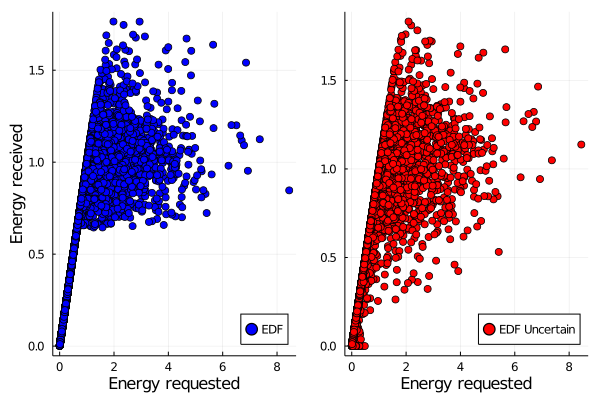

In [8]:
s1 = scatter(S_alg,Sa_alg,label=Algorithm, ylabel="Energy received",markershape=:circle,markersize=4,color=:blue, legend=:bottomright)
s2 = scatter(S_alg_uncertain,Sa_alg_uncertain,label=Algorithm* " Uncertain",markershape=:circle,markersize=4,color=:red, legend=:bottomright)
plot(s1, s2, layout = (1, 2), xlabel="Energy requested")

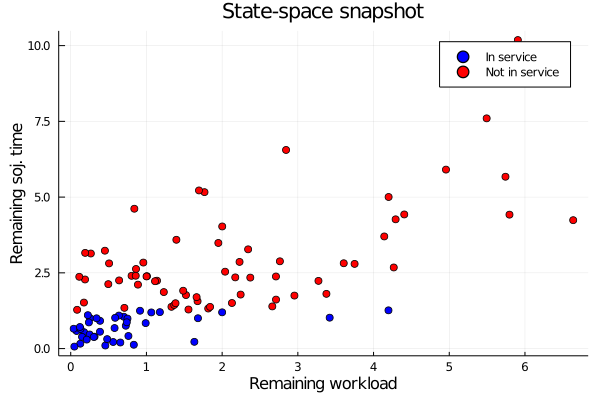

In [17]:
#State space of the last snapshot
snap = alg.snapshots[Int(end/2)];

w = [ev.currentWorkload for ev in snap.charging];
d = [ev.currentDeadline for ev in snap.charging];
on = [ev.currentPower>0 for ev in snap.charging];

p = plot(   xlabel = "Remaining workload",
            ylabel = "Remaining soj. time",
            title = "State-space snapshot")

scatter!(p,w[on.==true],d[on.==true],markershape=:circle,markersize=4,color=:blue,label="In service")
scatter!(p,w[on.==false],d[on.==false],markershape=:circle,markersize=4,color=:red,label="Not in service")

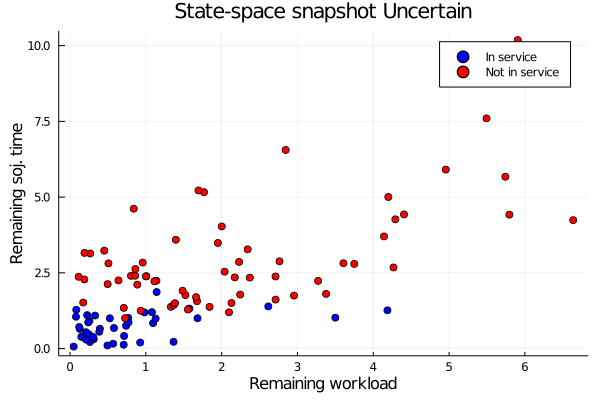

In [18]:
snap = alg_uncertain.snapshots[Int(end/2)];
w = [ev.currentWorkload for ev in snap.charging];
d = [ev.currentDeadline for ev in snap.charging];
on = [ev.currentPower>0 for ev in snap.charging];
p = plot(   xlabel = "Remaining workload",
            ylabel = "Remaining soj. time",
            title = "State-space snapshot Uncertain")

scatter!(p,w[on.==true],d[on.==true],markershape=:circle,markersize=4,color=:blue,label="In service")
scatter!(p,w[on.==false],d[on.==false],markershape=:circle,markersize=4,color=:red,label="Not in service")

In [24]:
using ProgressMeter

prog=Progress(length(snaps), dt=1, desc="Creando animacion... ");

anim = @animate for snapshot in alg.snapshots

    charging = [ev for ev in snapshot.charging]
    w = [ev.currentWorkload for ev in charging]
    d = [ev.currentDeadline for ev in charging]
    u = [ev.currentPower for ev in charging]

    p=scatter(w[u.>0],d[u.>0],markershape=:circle,color=:blue,legend=:none,xlims = (0,5/mu), ylims = (0,5/gamma));
    scatter!(p,w[u.==0],d[u.==0],markershape=:circle,color=:red,legend=:none, xlabel = "Remaining workload",
            ylabel = "Remaining soj. time",
            title = "State-space Animation");

    next!(prog);
end

gif(anim, "/tmp/anim.gif", fps = 10)

Creando animacion... 100%|██████████████████████████████| Time: 0:00:13
\tmp\anim.gif: No such file or directory


LoadError: failed process: Process(`'C:\Users\lucas\.julia\artifacts\7350a6401f1c0d38cc3518193083bc4f83adfe99\bin\ffmpeg.exe' -v 16 -framerate 10 -i 'C:\Users\lucas\AppData\Local\Temp\jl_OAclyu/%06d.png' -i 'C:\Users\lucas\AppData\Local\Temp\jl_OAclyu/palette.bmp' -lavfi paletteuse=dither=sierra2_4a -loop 0 -y '\tmp\anim.gif'`, ProcessExited(1)) [1]


In [ ]:
using ProgressMeter

prog=Progress(length(snaps), dt=1, desc="Creando animacion... ");

anim = @animate for snapshot in alg_uncertain.snapshots

    charging = [ev for ev in snapshot.charging]
    w = [ev.currentWorkload for ev in charging]
    d = [ev.currentDeadline for ev in charging]
    u = [ev.currentPower for ev in charging]

    p=scatter(w[u.>0],d[u.>0],markershape=:circle,color=:blue,legend=:none,xlims = (0,5/mu), ylims = (0,5/gamma));
    scatter!(p,w[u.==0],d[u.==0],markershape=:circle,color=:red,legend=:none xlabel = "Remaining workload",
            ylabel = "Remaining soj. time",
            title = "State-space Animation Uncertain");

    next!(prog);
end

gif(anim, "/tmp/anim.gif", fps = 10)